In [1]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot as plt
%matplotlib inline

# Use this for interactive plots
# %matplotlib notebook

In [2]:
# Simple 2D parabola R2 -> R, f = x^2 + y^2
def parabola_2d(in_vec):
    assert in_vec.shape == (2,)
    return in_vec[0]**2 + in_vec[1]**2

# Rosenbrock function
def rosenbrock(in_vec, a=1, b=100):
    assert in_vec.shape == (2,)
    return (a-in_vec[0])**2 + b*(in_vec[1]-in_vec[0]**2)**2

# Visualise cost surface for 2D function
def dense_visualise_2d(function, x_range, y_range, n_mesh, cmap='jet'):
    # Plot a range of values for visulation
    values_x = np.linspace(*x_range, num=n_mesh)
    values_y = np.linspace(*y_range, num=n_mesh)
    X, Y = np.meshgrid(values_x, values_y)

    # Obviously this can be vectorised, but the aim is to write a 
    # blackbox optimiser, so just operate on 2-vectors.
    theta = np.dstack([X, Y])
    Z = np.zeros_like(X)
    for r in range(n_mesh):
        for c in range(n_mesh):
            Z[r, c] = function(theta[r, c, :])

    # Surface plot
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.plot_surface(X, Y, Z, cmap=cmap)
    return theta, Z

In [3]:
def DE_optimiser(f, limits, F, CR, n_candidates=100, max_iter=1000, min_term=1e-5):
    assert limits.shape[1] == 2, 'Limits should be N x 2 matrix, min and max per parameter.'
    assert n_candidates >= 4, 'Must have >= 4 candidates.'
    assert 0 <= F <= 2, 'F in [0, 2].'
    assert 0 <= CR <= 1, 'CR in [0, 1].'
    
    n_dims = limits.shape[0]

    # Populate randomly in given intervals.
    candidates = np.zeros((n_candidates, n_dims))
    for candidate_ind in range(n_candidates):
        for dim_ind in range(n_dims):
            candidates[candidate_ind, dim_ind] = np.random.uniform(*limits[dim_ind])
    
    def best_f_eval():
        # N.B. We're using f and candidates from outer scope
        best_val = np.inf
        for candidate in candidates:
            current_val = f(candidate)
            if current_val < best_val:
                best_candidate = candidate
                best_val = current_val
        return best_candidate, best_val
    
    # Find best of initial candidates.
    best_val = best_f_eval()[-1]
            
    print('Initial best {}'.format(best_val))
    
    iters = 0
    while iters < max_iter and best_val > min_term:
        for candidate_ind, x in enumerate(candidates):
            indices = np.random.choice(
                list(set(range(0, n_candidates)) - set([candidate_ind])),
                3
            )
            a, b, c = candidates[indices]
            R = np.random.randint(n_dims)
            r = np.random.uniform(0., 1., n_dims)
            
            y = np.zeros_like(x)
            for i in range(n_dims):
                if r[i] < CR or i == R:
                    y[i] = a[i] + F * (b[i] - c[i])
                else:
                    y[i] = x[i]
            
            f_of_x = f(x)
            if f_of_x < best_val:
                best_val = f_of_x

            if f(y) < f(x):
                candidates[candidate_ind] = y
            
        iters += 1
    
    print('Iters: {}'.format(iters))
    best_val = best_f_eval()
    
    return best_f_eval()

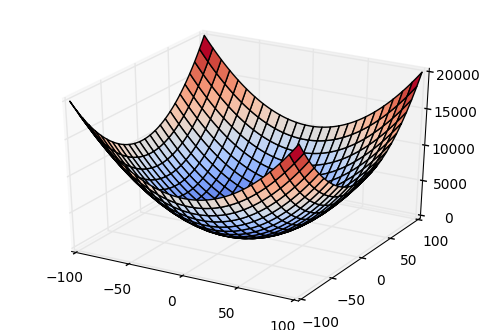

In [4]:
theta, Z = dense_visualise_2d(parabola_2d, (-100, 100), (-100, 100), 251, 'coolwarm')

In [5]:
print('Min cost is {}'.format(np.min(Z)))
min_ind = np.unravel_index(np.argmin(Z), Z.shape)
print('Parameters for min: {}'.format(theta[min_ind]))

Min cost is 0.0
Parameters for min: [ 0.  0.]


In [6]:
DE_optimiser(parabola_2d, np.array([[-100, 100],[-100, 100]]), 0.5, 0.5, 100, 10000, 0.)

Initial best 64.47732270146551
Iters: 1312


(array([ -1.01325462e-162,   1.31068975e-162]), 0.0)

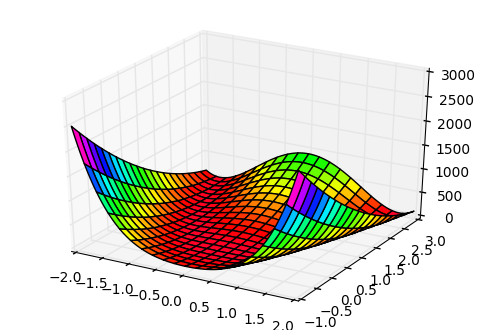

In [7]:
dense_visualise_2d(rosenbrock, (-2, 2), (-1, 3), 201, 'gist_rainbow');

In [8]:
# Rosenbrock function.
opt_theta, cost = DE_optimiser(
    rosenbrock,
    np.array([[-2, 2],[-1, 3]]),
    0.25, 0.95,
    n_candidates=150,
    max_iter=1000, 
    min_term=0.
)
opt_theta, cost

Initial best 0.022393877574083027
Iters: 90


(array([ 1.,  1.]), 0.0)

In [9]:
if opt_theta[0] == opt_theta[1] ** 2 and cost == 0.:
    print('Global!')

Global!
